In [1]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

In [2]:
# Pick GPU.
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#import torch
#from torch import nn
#from torch import optim
#from torch.utils.data import DataLoader

#print(torch.cuda.is_available())
#print(torch.cuda.device_count())
#print(torch.cuda.current_device())
#print(torch.cuda.device(0))
#print(torch.cuda.get_device_name(0))
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)

#from nflows.flows.base import Flow
#from nflows.distributions.normal import StandardNormal
#from nflows.transforms.base import CompositeTransform
#from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
#from nflows.transforms.permutations import ReversePermutation

# Utility imports
# General imports
import os
import tensorflow as tf
from scipy import stats

# Utility imports
from utils.losses import *
from utils.plotting import *
from utils.training import *

In [42]:
rc('text', usetex=False)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Corner Plot

In [5]:
mc = np.load("data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

sim_pt =  mc['sim_jets'][:, 0]
sim_eta = mc['sim_jets'][:, 1]
sim_phi = mc['sim_jets'][:, 2]
sim_m =   mc['sim_jets'][:, 3]
sim_mults = mc['sim_mults']
sim_lhas = mc['sim_lhas']
sim_widths = mc['sim_widths']
sim_ang2s = mc['sim_ang2s']
sim_tau2s = mc['sim_tau2s']
sim_sdms = mc['sim_sdms']
sim_zgs = mc['sim_zgs']

In [6]:
import seaborn as sns
import pandas as pd

In [7]:
df = pd.DataFrame(data = {'pt': sim_pt, 'eta': sim_eta, 'phi': sim_phi, 
                          'm': sim_m, 'widths': sim_widths, 'sdms': sim_sdms})

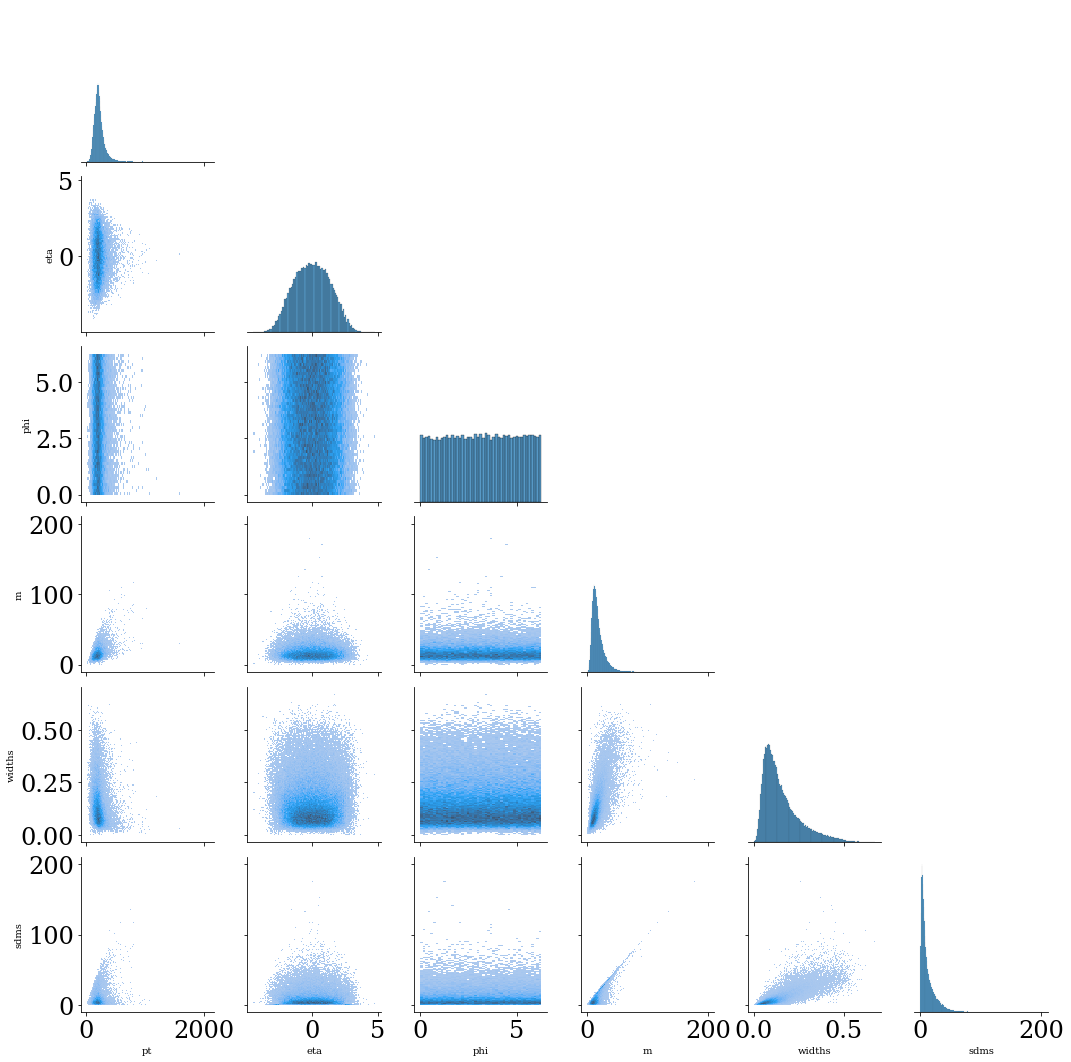

In [8]:
sns.pairplot(data = df, kind = 'hist', corner = True)
#plt.savefig('plots/zenodo/corner.pdf')

# Training

## BCE $C$ Parametrization

In [8]:
# Experiment parameters
num = 2 # 2 is old best flows, 3 is new best flows
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':6}
params_2 = {'loss':probit_bce, 'd':6, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':6,  'output': 'linear'}

filestr = 'models/zenodo/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'probit/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

if not os.path.isdir(filestr + 'sigmoid/'):
    os.mkdir(filestr + 'sigmoid/')
    
if not os.path.isdir(filestr + 'probit/'):
    os.mkdir(filestr + 'probit/')

if not os.path.isdir(filestr + 'arctan/'):
    os.mkdir(filestr + 'arctan/')

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/6/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/6/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [9]:
for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    model_2, trace = train(data, **params_2)
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

0 0.6807498335838318 	 100	0.6807949542999268 	 100	0.6811046600341797 	 100	
1 0.6810252666473389 	 100	0.6812636852264404 	 100	0.6808125376701355 	 100	
2 0.6809895038604736 	 100	0.6807305216789246 	 100	0.6811490058898926 	 100	
3 0.680742621421814 	 100	0.6807520985603333 	 100	0.6808843612670898 	 100	
4 0.6811879873275757 	 100	0.6812282204627991 	 100	0.6816086173057556 	 100	
5 0.6808313727378845 	 100	0.6810223460197449 	 100	0.6812440752983093 	 100	
6 0.6809666752815247 	 100	0.6811301112174988 	 100	0.6808277368545532 	 100	
7 0.6808173060417175 	 100	0.6809749007225037 	 100	0.681049108505249 	 100	
8 0.6809222102165222 	 100	0.681217610836029 	 100	0.6816218495368958 	 100	
9 0.6810382008552551 	 100	0.6808411478996277 	 100	0.6809601783752441 	 100	
10 0.6806327700614929 	 100	0.6811679005622864 	 100	0.680758535861969 	 100	
11 0.6803348660469055 	 100	0.6805156469345093 	 100	0.6807004809379578 	 100	
12 0.6811416149139404 	 100	0.6812277436256409 	 100	0.68070429563

## MSE $C$ Parametrization

In [10]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':6}
params_2 = {'loss':probit_mse, 'd':6, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':6,  'output': 'linear'}

filestr = 'models/zenodo/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'probit/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

if not os.path.isdir(filestr + 'sigmoid/'):
    os.mkdir(filestr + 'sigmoid/')
    
if not os.path.isdir(filestr + 'probit/'):
    os.mkdir(filestr + 'probit/')

if not os.path.isdir(filestr + 'arctan/'):
    os.mkdir(filestr + 'arctan/')

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/6/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/6/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [11]:
for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    model_2, trace = train(data, **params_2)
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

0 0.24389980733394623 	 100	0.24395599961280823 	 100	0.24395513534545898 	 100	
1 0.24378153681755066 	 100	0.24365399777889252 	 100	0.24385684728622437 	 100	
2 0.24396462738513947 	 100	0.24446256458759308 	 100	0.24404652416706085 	 100	
3 0.24384146928787231 	 100	0.24398337304592133 	 100	0.2440965622663498 	 100	
4 0.24405597150325775 	 100	0.2439134418964386 	 100	0.2439728081226349 	 100	
5 0.24385827779769897 	 100	0.24403789639472961 	 100	0.24384824931621552 	 100	
6 0.24395033717155457 	 100	0.24387921392917633 	 100	0.2442084699869156 	 100	
7 0.24392902851104736 	 100	0.24435299634933472 	 100	0.24389292299747467 	 100	
8 0.24390405416488647 	 100	0.2437431961297989 	 100	0.24424947798252106 	 100	
9 0.24397292733192444 	 100	0.24368253350257874 	 100	0.24385285377502441 	 100	
10 0.24383822083473206 	 100	0.2439071536064148 	 100	0.24391567707061768 	 100	
11 0.2440095990896225 	 100	0.24405862390995026 	 100	0.24378512799739838 	 100	
12 0.2440508008003235 	 100	0.243

## MLC $C$ Parametrization

In [12]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd': 6, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd': 6, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd': 6, 'output': 'linear'}

filestr = 'models/zenodo/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

if not os.path.isdir(filestr + 'relu/'):
    os.mkdir(filestr + 'relu/')
    
if not os.path.isdir(filestr + 'square/'):
    os.mkdir(filestr + 'square/')

if not os.path.isdir(filestr + 'exponential/'):
    os.mkdir(filestr + 'exponential/')

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/6/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/6/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [13]:
for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    model_2, trace = train(data, **params_2)
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

0 -0.017576823011040688 	 100	-0.015416326001286507 	 100	-0.023902175948023796 	 100	
1 -0.016771996393799782 	 100	-0.019318440929055214 	 100	-0.02516881376504898 	 100	
2 -0.016005825251340866 	 100	-0.01898694969713688 	 100	-0.02559828944504261 	 100	
3 -0.016691971570253372 	 100	-0.016937334090471268 	 100	-0.025114474818110466 	 100	
4 -0.01701538637280464 	 100	-0.017120394855737686 	 98	-0.02526748739182949 	 100	
5 -0.016678940504789352 	 100	-0.016628164798021317 	 100	-0.025177251547574997 	 100	
6 -0.016002438962459564 	 100	-0.019728386774659157 	 100	-0.02542060986161232 	 100	
7 -0.017741527408361435 	 100	-0.016484934836626053 	 100	-0.02591281197965145 	 100	
8 -0.015976281836628914 	 100	-0.017405280843377113 	 100	-0.02490447834134102 	 100	
9 -0.02005317620933056 	 100	-0.014784259721636772 	 100	-0.02527758851647377 	 100	
10 -0.01633833535015583 	 100	-0.01730702817440033 	 100	-0.024120375514030457 	 100	
11 -0.016515523195266724 	 100	-0.014795045368373394 	 

## SQR $C$ Parametrization

In [14]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd': 6, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd': 6, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd': 6, 'output': 'linear'}

filestr = 'models/zenodo/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

if not os.path.isdir(filestr + 'relu/'):
    os.mkdir(filestr + 'relu/')
    
if not os.path.isdir(filestr + 'square/'):
    os.mkdir(filestr + 'square/')

if not os.path.isdir(filestr + 'exponential/'):
    os.mkdir(filestr + 'exponential/')

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/6/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/6/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [15]:
for i in range(reps):
    print(i, end = ' ')
    model_1, trace = train(data, **params_1)
    model_2, trace = train(data, **params_2)
    model_3, trace = train(data, **params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

0 0.9939092397689819 	 100	1.3555971384048462 	 77	0.987607479095459 	 100	
1 0.9957083463668823 	 100	0.9925281405448914 	 100	0.988113284111023 	 100	
2 0.9941025376319885 	 100	1.4108279943466187 	 100	0.9876770377159119 	 100	
3 0.9932873249053955 	 100	1.0124626159667969 	 100	0.9875147342681885 	 100	
4 0.9932783842086792 	 100	1.5937097072601318 	 38	0.9881188869476318 	 100	
5 0.9931028485298157 	 100	1.325481653213501 	 23	0.9877566695213318 	 100	
6 0.997477114200592 	 100	0.9990058541297913 	 94	0.9874617457389832 	 100	
7 1.002010464668274 	 100	1.2413169145584106 	 100	0.9877831339836121 	 100	
8 0.9975252151489258 	 100	1.895203948020935 	 65	0.9873663187026978 	 100	
9 0.9934887290000916 	 100	1.0226466655731201 	 100	0.9874014854431152 	 100	
10 0.9963849782943726 	 100	6.895471096038818 	 23	0.9880700707435608 	 100	
11 0.9953064322471619 	 100	1.2968789339065552 	 42	0.9875274896621704 	 100	
12 1.007182002067566 	 100	1.0780813694000244 	 100	0.9876316785812378 	 100

## $p$-MSE

In [16]:
# Physics
#num = 0    # p* search
#num = 1    # p*
#num = 2     # p*
#num = 3    # p* search
#num = 4
num = 7
reps = 100

# File parameters
filestr = 'models/zenodo/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/6/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/6/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)
p_star = 1.64
#p_star = 1.92

In [18]:
params = {'loss': get_mse(p_star), 'd': 6}
for i in range(reps):
    print(i, end = '\t')
    model, trace = train(data, **params)
    model.save_weights(mse_filestr.format(i))
    print()

0	0.31134119629859924 	 100	
1	0.31113749742507935 	 100	
2	0.3110676109790802 	 100	
3	0.31142938137054443 	 100	
4	0.31123679876327515 	 100	
5	0.31135255098342896 	 100	
6	0.31124353408813477 	 100	
7	0.31094712018966675 	 100	
8	0.31109002232551575 	 100	
9	0.3113122582435608 	 100	
10	0.31132787466049194 	 100	
11	0.31114140152931213 	 100	
12	0.31138747930526733 	 100	
13	0.31105074286460876 	 100	
14	0.3112776577472687 	 100	
15	0.3110027313232422 	 100	
16	0.3112134039402008 	 100	
17	0.3111918270587921 	 100	
18	0.31134849786758423 	 100	
19	0.31125569343566895 	 100	
20	0.3110903799533844 	 100	
21	0.3112110495567322 	 100	
22	0.3111695945262909 	 100	
23	0.311134397983551 	 100	
24	0.3112247586250305 	 100	
25	0.31122279167175293 	 100	
26	0.3111664652824402 	 100	
27	0.3111173212528229 	 100	
28	0.3110634982585907 	 100	
29	0.31131985783576965 	 100	
30	0.3111538290977478 	 100	
31	0.31108126044273376 	 100	
32	0.31113436818122864 	 100	
33	0.31108957529067993 	 100	
34	0.3

## $r$-SQR

In [19]:
# Physics
#num = 0 (r-SQR search)
#num = 1    # r*
#num = 2     # r*
#num = 4
num = 7
reps = 100

# File parameters
filestr = 'models/zenodo/ab_sqr/set_{}/'.format(num)
sqr_filestr = filestr + 'model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/6/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/6/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

r_star = 1.1

In [20]:
params = {'loss': get_exp_sqr(r_star), 'd': 6, 'output': 'linear'}
for i in range(reps):
    print(i, end = '\t')
    model, trace = train(data, **params)
    model.save_weights(sqr_filestr.format(i))
    print()

0	0.9876051545143127 	 100	
1	0.9874898195266724 	 100	
2	0.9877309799194336 	 100	
3	0.9878297448158264 	 100	
4	0.9878814220428467 	 100	
5	0.9876910448074341 	 100	
6	0.987701952457428 	 100	
7	0.987568736076355 	 100	
8	0.987612247467041 	 100	
9	0.9880167245864868 	 100	
10	0.9875416159629822 	 100	
11	0.9876114726066589 	 100	
12	0.9882123470306396 	 100	
13	0.9875978231430054 	 100	
14	0.9874792695045471 	 100	
15	0.987876296043396 	 100	
16	0.9874691963195801 	 100	
17	0.9879523515701294 	 100	
18	0.987697422504425 	 100	
19	0.9875177145004272 	 100	
20	0.9881123304367065 	 100	
21	0.9873196482658386 	 100	
22	0.9875982403755188 	 100	
23	0.9874206781387329 	 100	
24	0.9874358773231506 	 100	
25	0.9875488877296448 	 100	
26	0.9875332713127136 	 100	
27	0.9875645041465759 	 100	
28	0.9875672459602356 	 100	
29	0.9878658652305603 	 100	
30	0.9872973561286926 	 100	
31	0.9873481392860413 	 100	
32	0.9876177310943604 	 100	
33	0.9879036545753479 	 100	
34	0.9877964854240417 	 100	


# MAEs

In [2]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

True
4
0
Quadro RTX 6000
cuda:0


In [6]:
import numpy as np

In [3]:
d = 6

num_layers = 5

# DATA FLOW
base_dist = StandardNormal(shape=[d])
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=d))
    transforms.append(MaskedAffineAutoregressiveTransform(features=d, 
                                                          hidden_features=8))
transform = CompositeTransform(transforms)
dt_flow = Flow(transform, base_dist)
dt_flow.to(device)
ckpt = torch.load('flows/nflows/dat/8/best/ckpt_67')
dt_flow.load_state_dict(ckpt['model_state_dict'])
dt_flow.eval()

# MC FLOW
base_dist = StandardNormal(shape=[d])
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=d))
    transforms.append(MaskedAffineAutoregressiveTransform(features=d, 
                                                          hidden_features=8))
transform = CompositeTransform(transforms)
mc_flow = Flow(transform, base_dist)
mc_flow.to(device)
ckpt = torch.load('flows/nflows/sim/8/best/ckpt_39')
mc_flow.load_state_dict(ckpt['model_state_dict'])
mc_flow.eval();

In [7]:
X_mae = np.load('data/zenodo/fold/6/X_tst.npy')
lr_tst = np.load('data/zenodo/fold/6/lr_tst.npy')

In [8]:
def mae(model_lr):
    abs_dif = abs(model_lr(X_mae) - lr_tst)
    #print(np.mean(abs_dif < 100), end = ' ')
    return abs_dif[abs_dif < 100].mean()

## BCE

In [29]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':6}
params_2 = {'loss':probit_bce, 'd':6, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':6,  'output': 'linear'}

filestr = 'models/zenodo/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'probit/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/6/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/6/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [30]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = probit_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3, where = ~np.isnan(maes_3))

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

abs_dif_1 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_1])
abs_dif_2 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_2])
abs_dif_3 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_3])

# Save results
np.save(filestr + 'maes_1.npy', maes_1)
np.save(filestr + 'maes_2.npy', maes_2)
np.save(filestr + 'maes_3.npy', maes_3)

np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'abs_dif_1.npy', abs_dif_1)
np.save(filestr + 'abs_dif_2.npy', abs_dif_2)
np.save(filestr + 'abs_dif_3.npy', abs_dif_3)

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

3123/3123 [==============================] - 2s 647us/step
0.4291442 0.43003857 0.4293747
0.0022225922 0.0032804844 0.0022632962


In [31]:
abs_dif_1 = np.load(filestr + 'abs_dif_1.npy')
(abs_dif_1 > 100).mean()

0.0015213300502472324

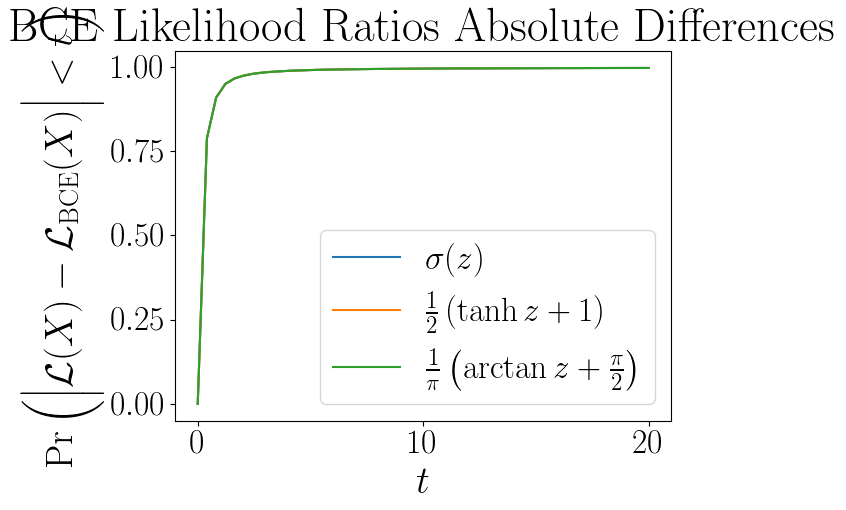

In [32]:
aa = abs_dif_1.flatten()
bb = abs_dif_2.flatten()
cc = abs_dif_3.flatten()

ts = np.linspace(0, 20)
plt.plot(ts, [(aa < t).mean() for t in ts], label = r'$\sigma(z)$')
plt.plot(ts, [(bb < t).mean() for t in ts], label = r'$\frac{1}{2}\left(\tanh{z} + 1\right)$')
plt.plot(ts, [(cc < t).mean() for t in ts], label = r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$')
plt.legend()

plt.xlabel(r'$t$')
plt.ylabel(r'$\text{Pr}\left(\Big|\mathcal{L}(X) - \mathcal{L}_\text{BCE}(X)\Big| < t\right)$')
plt.title(r'BCE Likelihood Ratios Absolute Differences')

plt.savefig('plots/zenodo/bce_threshold_plot.png', 
            dpi=300, 
            bbox_inches='tight')

## MSE

In [33]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':6}
params_2 = {'loss':probit_mse, 'd':6, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':6,  'output': 'linear'}

filestr = 'models/zenodo/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'probit/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/6/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/6/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [34]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = probit_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3, where = ~np.isnan(maes_3))

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

abs_dif_1 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_1])
abs_dif_2 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_2])
abs_dif_3 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_3])

# Save results
np.save(filestr + 'maes_1.npy', maes_1)
np.save(filestr + 'maes_2.npy', maes_2)
np.save(filestr + 'maes_3.npy', maes_3)

np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'abs_dif_1.npy', abs_dif_1)
np.save(filestr + 'abs_dif_2.npy', abs_dif_2)
np.save(filestr + 'abs_dif_3.npy', abs_dif_3)

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'models/zenodo/c_mse/set_3/sigmoid/model_0.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
abs_dif_1 = np.load(filestr + 'abs_dif_1.npy')
(abs_dif_1 > 100).mean()

In [ ]:
aa = abs_dif_1.flatten()
bb = abs_dif_2.flatten()
cc = abs_dif_3.flatten()

ts = np.linspace(0, 20)
plt.plot(ts, [(aa < t).mean() for t in ts], label = r'$\sigma(z)$')
plt.plot(ts, [(bb < t).mean() for t in ts], label = r'$\frac{1}{2}\left(\tanh{z} + 1\right)$')
plt.plot(ts, [(cc < t).mean() for t in ts], label = r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$')
plt.legend()

plt.xlabel(r'$t$')
plt.ylabel(r'$\text{Pr}\left(\Big|\mathcal{L}(X) - \mathcal{L}_\text{MSE}(X)\Big| < t\right)$')
plt.title(r'MSE Likelihood Ratios Absolute Differences')

plt.savefig('plots/zenodo/mse_threshold_plot.png', 
            dpi=300, 
            bbox_inches='tight')

## MLC

In [ ]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd': 6, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd': 6, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd': 6, 'output': 'linear'}

filestr = 'models/zenodo/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/6/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/6/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3, where = ~np.isnan(maes_3))

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

abs_dif_1 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_1])
abs_dif_2 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_2])
abs_dif_3 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_3])

# Save results
np.save(filestr + 'maes_1.npy', maes_1)
np.save(filestr + 'maes_2.npy', maes_2)
np.save(filestr + 'maes_3.npy', maes_3)

np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'abs_dif_1.npy', abs_dif_1)
np.save(filestr + 'abs_dif_2.npy', abs_dif_2)
np.save(filestr + 'abs_dif_3.npy', abs_dif_3)

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

In [ ]:
abs_dif_3 = np.load(filestr + 'abs_dif_3.npy')
(abs_dif_3 > 100).mean()

In [ ]:
aa = abs_dif_1.flatten()
bb = abs_dif_2.flatten()
cc = abs_dif_3.flatten()

ts = np.linspace(0, 20)
plt.plot(ts, [(aa < t).mean() for t in ts], label = r'${\rm ReLU}(z)$')
plt.plot(ts, [(bb < t).mean() for t in ts], label = r'$z^2$')
plt.plot(ts, [(cc < t).mean() for t in ts], label = r'$\exp(z)$')
plt.legend()

plt.xlabel(r'$t$')
plt.ylabel(r'$\text{Pr}\left(\Big|\mathcal{L}(X) - \mathcal{L}_\text{MLC}(X)\Big| < t\right)$')
plt.title(r'MLC Likelihood Ratios Absolute Differences')

plt.savefig('plots/zenodo/mlc_threshold_plot.png', 
            dpi=300, 
            bbox_inches='tight')

## SQR

In [39]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd': 6, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd': 6, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd': 6, 'output': 'linear'}

filestr = 'models/zenodo/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/6/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/6/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

In [40]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2, where = ~np.isnan(maes_2))
avg_3 = np.mean(maes_3, where = ~np.isnan(maes_3))

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1, where = ~np.isnan(maes_2))
std_3 = np.std(maes_3, ddof = 1)

abs_dif_1 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_1])
abs_dif_2 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_2])
abs_dif_3 = np.array([abs(lr(X_mae) - lr_tst) for lr in lrs_3])

# Save results
np.save(filestr + 'maes_1.npy', maes_1)
np.save(filestr + 'maes_2.npy', maes_2)
np.save(filestr + 'maes_3.npy', maes_3)

np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'abs_dif_1.npy', abs_dif_1)
np.save(filestr + 'abs_dif_2.npy', abs_dif_2)
np.save(filestr + 'abs_dif_3.npy', abs_dif_3)

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

  57/3123 [..............................] - ETA: 2s  

/tmp/ipykernel_2098/3780721232.py:4: RuntimeWarning: Mean of empty slice.
  return abs_dif[abs_dif < 100].mean()
/clusterfs/ml4hep/shahzar/miniconda/envs/test/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


3123/3123 [==============================] - 2s 667us/step
0.5085542 0.8895595 0.42936096
0.08211738 0.26187488 0.002094427


In [41]:
abs_dif_3 = np.load(filestr + 'abs_dif_3.npy')
(abs_dif_3 > 100).mean()

0.0015214301443356756

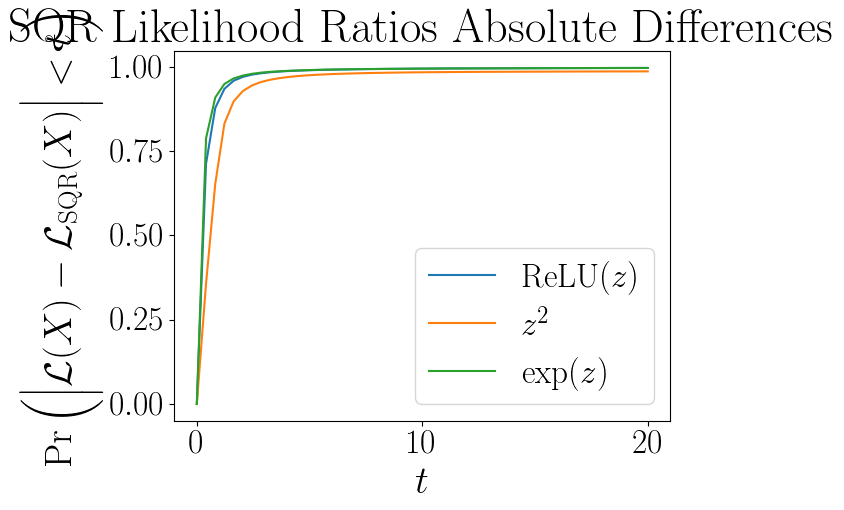

In [42]:
aa = abs_dif_1.flatten()
bb = abs_dif_2.flatten()
cc = abs_dif_3.flatten()

ts = np.linspace(0, 20)
plt.plot(ts, [(aa < t).mean() for t in ts], label = r'${\rm ReLU}(z)$')
plt.plot(ts, [(bb < t).mean() for t in ts], label = r'$z^2$')
plt.plot(ts, [(cc < t).mean() for t in ts], label = r'$\exp(z)$')
plt.legend()

plt.xlabel(r'$t$')
plt.ylabel(r'$\text{Pr}\left(\Big|\mathcal{L}(X) - \mathcal{L}_\text{SQR}(X)\Big| < t\right)$')
plt.title(r'SQR Likelihood Ratios Absolute Differences')

plt.savefig('plots/zenodo/sqr_threshold_plot.png', 
            dpi=300, 
            bbox_inches='tight')

## AB MSE

In [8]:
# Experiment parameters
num = 6
reps = 20

# File parameters
filestr = 'models/zenodo/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/6/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/6/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

#ps = np.round(np.append(np.linspace(-2, 2, 101)[:-1], 
#                        np.linspace(2, 3, 101)), 
#              2)
ps = np.round(np.linspace(-2, 3, 126), 2)

In [9]:
# Get model likelihood ratios.
avgs = []
for p in ps:
    print(p, end = '\t')
    lrs = [None] * reps
    params = {'loss':get_mse(p), 'd': 6}
    for i in range(reps):
        model = create_model(**params)
        model.load_weights(mse_filestr.format(p, i))
        lrs[i] = pow_odds_lr(model, p, m, s)
    
    maes = [mae(lr) for lr in lrs]
    avgs += [np.nanmean(maes)]
    print(avgs[-1])

avgs = np.array(avgs)

-2.0	

2023-12-08 03:57:19.518265: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 03:57:20.173180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14604 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


0.48129338
-1.96	0.48538765
-1.92	0.4825088
-1.88	0.4795502
-1.84	0.47858262
-1.8	0.47827435
-1.76	0.48097983
-1.72	0.48028392
-1.68	0.47976536
-1.64	0.48057127
-1.6	0.47896916
-1.56	0.47802362
-1.52	0.4770419
-1.48	0.47820836
-1.44	0.47793478
-1.4	0.47804102
-1.36	0.47636533
-1.32	0.4763042
-1.28	0.47745633
-1.24	0.47490078
-1.2	0.47492272
-1.16	0.47106862
-1.12	0.47603065
-1.08	0.47584152
-1.04	0.47477412
-1.0	0.47353116
-0.96	0.47443128
-0.92	0.4725911
-0.88	0.47378534
-0.84	0.4740251
-0.8	0.47583014
-0.76	0.47309962
-0.72	0.47436196
-0.68	0.4732011
-0.64	0.47411084
-0.6	0.47402272
-0.56	0.47204867
-0.52	0.47022676
-0.48	0.47097844
-0.44	0.47016352
-0.4	0.4714771
-0.36	0.47016114
-0.32	0.46989447
-0.28	0.4709235
-0.24	0.474423
-0.2	0.47139826
-0.16	0.47130466
-0.12	0.47118074
-0.08	0.4700502
-0.04	0.4719583
0.0	0.61402404
0.04	

/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:236: RuntimeWarning: divide by zero encountered in divide
  return np.squeeze( (f / (1. - f))**(p - 1))
/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:236: RuntimeWarning: divide by zero encountered in power
  return np.squeeze( (f / (1. - f))**(p - 1))
/tmp/ipykernel_2994917/3780721232.py:2: RuntimeWarning: invalid value encountered in subtract
  abs_dif = abs(model_lr(X_mae) - lr_tst)
/tmp/ipykernel_2994917/3780721232.py:4: RuntimeWarning: Mean of empty slice.
  return abs_dif[abs_dif < 100].mean()
/clusterfs/ml4hep/shahzar/miniconda/envs/multifold/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


1.2983596
0.08	1.4176983
0.12	1.4868991
0.16	1.4531546
0.2	1.475645
0.24	1.4419913
0.28	1.5221223
0.32	1.5006496
0.36	1.6045042
0.4	1.7340004
0.44	1.6875654
0.48	1.6215514
0.52	1.708117
0.56	1.8786714
0.6	6.3461056
0.64	6.0436764
0.68	2.2255778
0.72	5.9186583
0.76	3.9198303
0.8	5.224404
0.84	7.467841
0.88	10.154812
0.92	8.453567
0.96	1.5727605
1.0	0.57734525
1.04	0.48515978
1.08	0.4873159
1.12	0.48172674
1.16	0.47899047
1.2	0.4773584
1.24	0.4757421
1.28	0.4744462
1.32	0.47217408
1.36	0.4716521
1.4	0.47200584
1.44	0.4706556
1.48	0.4698909
1.52	0.46919456
1.56	0.47052807
1.6	0.46928865
1.64	0.46875268
1.68	0.46907467
1.72	0.4691823
1.76	0.46967036
1.8	0.4699498
1.84	0.4690176
1.88	0.46892166
1.92	0.46994537
1.96	0.46994853
2.0	0.4702591
2.04	0.46909636
2.08	0.46973372
2.12	0.46944666
2.16	0.47028333
2.2	0.4700223
2.24	0.47054178
2.28	0.46955866
2.32	0.4702777
2.36	0.47210234
2.4	0.47015905
2.44	0.47026
2.48	0.46982846
2.52	0.4699398
2.56	0.47206992
2.6	0.47054505
2.64	0.47240385
2.68	0.4

In [10]:
# Save results
np.save(filestr + 'avgs', avgs)

In [9]:
avgs = np.load(filestr + 'avgs.npy')
#avgs_2 = np.load(filestr + 'avgs_2.npy')

In [10]:
#avgs = np.append(avgs, avgs_2[1:])
#ps = np.append(np.linspace(-2, 2, 101), np.linspace(2, 3, 101)[1:])

In [11]:
ps[avgs == np.nanmin(avgs)]

array([1.64])

In [24]:
# Expand scan

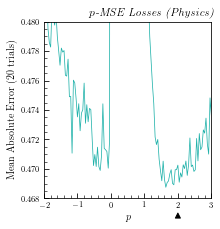

In [37]:
w = 3
h = 3.25

plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='lightseagreen', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error (20 Trials)')
plt.xlabel(r'$p$')
plt.ylim(0.468, 0.48)
plt.xlim(-2, 3)
plt.gca().annotate(' ', (2.0, 0.468 - 0.0010), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)

plt.title(r"\it $p$-MSE Losses (Physics)",loc="right");
plt.savefig('plots/zenodo/ab_mse_6.pdf', 
            dpi=300, 
            bbox_inches='tight')

## AB SQR

In [34]:
# Experiment parameters
num = 6
reps = 20

# File parameters
filestr = 'models/zenodo/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/6/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/6/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

In [14]:
lin_avgs = []
exp_avgs = []

for r in rs:
    print(r, end = '\t')
    lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    lin_params = {'loss': get_sqr(r), 'd': 6, 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'd': 6, 'output':'linear'}
    
    for i in range(reps):
        lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        lin_model.load_weights(lin_filestr.format(r, i))
        exp_model.load_weights(exp_filestr.format(r, i))
        
        lin_lrs[i] = pow_lr(lin_model, r, m, s)
        exp_lrs[i] = pow_exp_lr(exp_model, r, m, s)
    
    lin_maes = [mae(lr) for lr in lin_lrs]
    exp_maes = [mae(lr) for lr in exp_lrs]
    
    lin_avgs += [np.nanmean(lin_maes)]
    exp_avgs += [np.nanmean(exp_maes)]

-2.0	-1.95	-1.9	-1.85	-1.8	-1.75	-1.7	-1.65	-1.6	-1.55	-1.5	-1.45	-1.4	-1.35	-1.3	-1.25	-1.2	-1.15	-1.1	-1.05	-1.0	-0.95	-0.9	-0.85	-0.8	-0.75	-0.7	-0.65	-0.6	-0.55	

/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:224: RuntimeWarning: divide by zero encountered in power
  return np.squeeze(f**p)


-0.5	-0.45	-0.4	-0.35	-0.3	-0.25	-0.2	-0.15	-0.1	

/tmp/ipykernel_2994917/3780721232.py:4: RuntimeWarning: Mean of empty slice.
  return abs_dif[abs_dif < 100].mean()


-0.05	-0.046	-0.042	-0.038	

/tmp/ipykernel_2994917/3780721232.py:2: RuntimeWarning: invalid value encountered in subtract
  abs_dif = abs(model_lr(X_mae) - lr_tst)


-0.034	-0.03	-0.026	-0.022	-0.018	-0.014	-0.01	-0.006	-0.002	0.0	0.002	

/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:230: RuntimeWarning: overflow encountered in exp
  return np.squeeze(np.exp(f)**p)


0.006	0.01	0.014	0.018	0.022	0.026	0.03	0.034	0.038	0.042	0.046	0.05	0.1	0.15	0.2	0.25	0.3	0.35	0.4	0.45	0.5	0.55	0.6	0.65	0.7	0.75	0.8	0.85	0.9	0.95	1.0	1.05	1.1	1.15	1.2	1.25	1.3	1.35	1.4	1.45	1.5	1.55	1.6	1.65	1.7	1.75	1.8	1.85	1.9	1.95	2.0	

In [15]:
# Save results
lin_avgs = np.array(lin_avgs)
exp_avgs = np.array(exp_avgs)

np.save(filestr + 'lin_avgs', lin_avgs)
np.save(filestr + 'exp_avgs', exp_avgs)

In [35]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == np.nanmin(lin_avgs)], rs[exp_avgs == np.nanmin(exp_avgs)]

(array([-0.002]), array([1.1]))

In [18]:
from matplotlib import rc
rc('text', usetex=False)

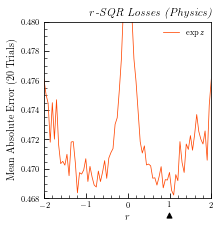

In [39]:
w = 3
h = 3.25

plt.figure(figsize = (w, h))

plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='orangered', lw = 0.75)
plt.legend(frameon = False)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error (20 Trials)')
plt.xlabel(r'$r$')
plt.ylim(0.468, 0.48)
plt.xlim(-2, 2)
plt.gca().annotate(' ', (1.0, 0.468 - 0.0010), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)

plt.title(r"\it $r$-SQR Losses (Physics)", loc="right");
plt.savefig('plots/zenodo/rsqr_physics_6.pdf', 
            dpi=300, 
            bbox_inches='tight')

## $p^*$-MSE

In [35]:
# Physics
#num = 0    # p* search
num = 7    # p*
reps = 100

# File parameters
filestr = 'models/zenodo/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/6/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/6/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)
p_star = 1.64

In [36]:
lrs = [None] * reps
params = {'loss':get_mse(p_star), 'd': 6}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(mse_filestr.format(i))
    lrs[i] = pow_odds_lr(model, p_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

3123/3123 [==============================] - 3s 699us/step
0.4309025 0.0001599132432602346


## $r^*$-SQR

In [37]:
# Physics
#num = 0 (r-SQR search)
num = 7    # r*
reps = 100

# File parameters
filestr = 'models/zenodo/ab_sqr/set_{}/'.format(num)
sqr_filestr = filestr + 'model_{}.h5'

if not os.path.isdir(filestr):
    os.mkdir(filestr)

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/6/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/6/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

r_star = 1.1

In [38]:
lrs = [None] * reps
params = {'loss':get_exp_sqr(r_star), 'd': 6, 'output': 'linear'}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(sqr_filestr.format(i))
    lrs[i] = pow_exp_lr(model, r_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

3123/3123 [==============================] - 2s 617us/step
0.42908671 0.00024035547394305468


# Check NaNs

## BCE

In [ ]:
# Experiment parameters
num = 0
filestr = 'models/zenodo/c_bce/set_{}/'.format(num)

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
X_mae = np.load('data/zenodo/fold/' + 'X_tst.npy')
abs_dif_1 = np.load(filestr + 'abs_dif_1.npy')

In [ ]:
bad = X_mae[np.any(abs_dif_1 > 100, axis = 0)]

In [ ]:
plt.scatter(X[:, 0], X[:, 1], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 0], bad[:, 1], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$p_T$')
plt.ylabel(r'$\eta$')
plt.title('Points with BCE MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/bce_pt_eta.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 0], X[:, 2], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 0], bad[:, 2], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$p_T$')
plt.ylabel(r'$\phi$')
plt.title('Points with BCE MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/bce_pt_phi.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 0], X[:, 3], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 0], bad[:, 3], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$p_T$')
plt.ylabel(r'$m$')
plt.title('Points with BCE MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/bce_pt_m.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 1], X[:, 2], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 1], bad[:, 2], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\phi$')
plt.title('Points with BCE MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/bce_eta_phi.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 1], X[:, 3], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 1], bad[:, 3], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$m$')
plt.title('Points with BCE MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/bce_eta_m.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 2], X[:, 3], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 2], bad[:, 3], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$m$')
plt.title('Points with BCE MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/bce_phi_m.png', 
            dpi=300, 
            bbox_inches='tight')

## MLC

In [ ]:
# Experiment parameters
num = 0
filestr = 'models/zenodo/c_mlc/set_{}/'.format(num)

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
X_mae = np.load('data/zenodo/fold/' + 'X_tst.npy')
abs_dif_1 = np.load(filestr + 'abs_dif_1.npy')

In [ ]:
bad = X_mae[np.any(abs_dif_1 > 100, axis = 0)]

In [ ]:
plt.scatter(X[:, 0], X[:, 1], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 0], bad[:, 1], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$p_T$')
plt.ylabel(r'$\eta$')
plt.title('Points with MLC MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/mlc_pt_eta.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 0], X[:, 2], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 0], bad[:, 2], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$p_T$')
plt.ylabel(r'$\phi$')
plt.title('Points with MLC MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/mlc_pt_phi.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 0], X[:, 3], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 0], bad[:, 3], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$p_T$')
plt.ylabel(r'$m$')
plt.title('Points with MLC MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/mlc_pt_m.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 1], X[:, 2], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 1], bad[:, 2], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\phi$')
plt.title('Points with MLC MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/mlc_eta_phi.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 1], X[:, 3], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 1], bad[:, 3], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$m$')
plt.title('Points with MLC MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/mlc_eta_m.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
plt.scatter(X[:, 2], X[:, 3], alpha = 0.01, label = 'Flow')
plt.scatter(bad[:, 2], bad[:, 3], alpha = 0.5, c = 'red', label = '> 100')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$m$')
plt.title('Points with MLC MAE Exceeding 100', loc = 'left')

plt.savefig('plots/zenodo/mlc_phi_m.png', 
            dpi=300, 
            bbox_inches='tight')

# Random Slice

In [7]:
X = np.load('data/zenodo/fold/X_trn.npy')
y = np.load('data/zenodo/fold/y_trn.npy')

In [8]:
stats.mode(X)

ModeResult(mode=array([[218.1418   ,  -2.0407841,   4.4148946,  22.070618 ]],
      dtype=float32), count=array([[9, 6, 8, 9]]))

In [9]:
mode_pT = 218
mode_eta = 0
mode_phi = 4.4
mode_m = 22

## $\phi$ Scan

In [10]:
# Get a one-dimensional slice of test points.
phis = np.linspace(0, 2*np.pi, 1201).reshape(-1, 1)
pTs = np.repeat(mode_pT, len(phis)).reshape(-1, 1)
etas = np.repeat(mode_eta, len(phis)).reshape(-1, 1)
ms = np.repeat(mode_m, len(phis)).reshape(-1, 1)

xs = np.hstack([pTs, etas, phis, ms])
var = phis
var_label = r'$\phi$'
var_string = 'phi'

lr_true = lr(xs)

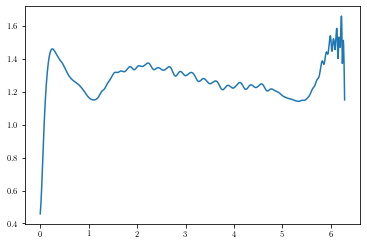

In [11]:
plt.plot(phis, lr_true)

### BCE

In [34]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':4}
params_2 = {'loss':tanh_bce, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it BCE $\phi$ Scan'
filename = 'plots/zenodo/scans/bce_phi.png'

In [35]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [36]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [37]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

In [38]:
cs = ['crimson', 'orangered', 'darkorange']
lss = [':', '--', '-.']

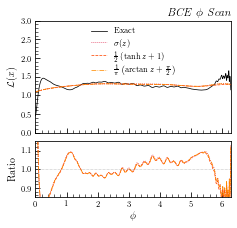

In [39]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')
axs[0].legend(frameon = False)

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.85, 1.15);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### MSE

In [17]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':4}
params_2 = {'loss':tanh_mse, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it MSE $\phi$ Scan'
filename = 'plots/zenodo/scans/mse_phi.png'

In [18]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [19]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [20]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

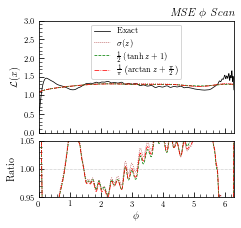

In [21]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.85, 1.15);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### MLC

In [22]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 3)
title = r'\it MLC $\phi$ Scan'
filename = 'plots/zenodo/scans/mlc_phi.png'

In [23]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [24]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [25]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

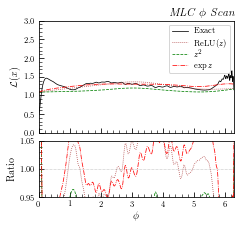

In [26]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### SQR

In [27]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 3)
title = r'\it SQR $\phi$ Scan'
filename = 'plots/zenodo/scans/sqr_phi.png'

In [28]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [29]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [30]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

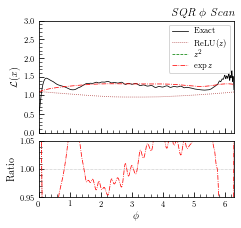

In [31]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.85, 1.15);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

## $p_T$ Scan

In [68]:
# Get a one-dimensional slice of test points.
pTs = np.linspace(0, 750, 1201).reshape(-1, 1)
etas = np.repeat(mode_eta, len(pTs)).reshape(-1, 1)
phis = np.repeat(mode_phi, len(pTs)).reshape(-1, 1)
ms = np.repeat(mode_m, len(pTs)).reshape(-1, 1)

xs = np.hstack([pTs, etas, phis, ms])
var = pTs
var_label = r'$p_T$'
var_string = 'pT'

lr_true = lr(xs)

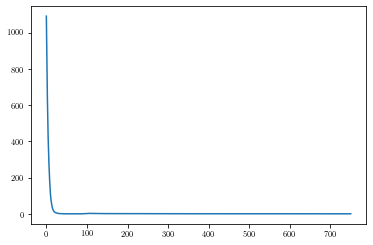

In [69]:
plt.plot(pTs, lr_true)

### BCE

In [70]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':4}
params_2 = {'loss':tanh_bce, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it BCE $\phi$ Scan'
filename = 'plots/zenodo/scans/bce_phi.png'

In [71]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [72]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [73]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

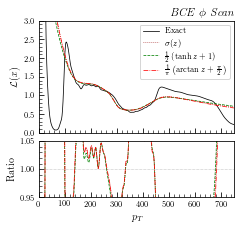

In [74]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### MSE

In [75]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':4}
params_2 = {'loss':tanh_mse, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it MSE $\p_T$ Scan'
filename = 'plots/zenodo/scans/mse_phi.png'

In [76]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [77]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [78]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

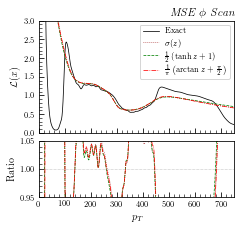

In [79]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### MLC

In [80]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 3)
title = r'\it MLC $\phi$ Scan'
filename = 'plots/zenodo/scans/mlc_phi.png'

In [81]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [82]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [83]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

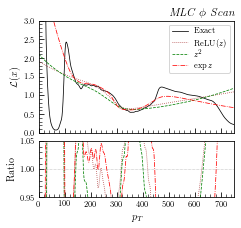

In [84]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### SQR

In [85]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 3)
title = r'\it MLC $\phi$ Scan'
filename = 'plots/zenodo/scans/mlc_phi.png'

In [86]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [87]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [88]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

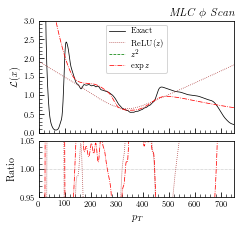

In [89]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

## $\eta$ Scan

In [90]:
# Get a one-dimensional slice of test points.
etas = np.linspace(-5, 5, 1001).reshape(-1, 1)
pTs = np.repeat(mode_pT, len(etas)).reshape(-1, 1)
phis = np.repeat(mode_phi, len(etas)).reshape(-1, 1)
ms = np.repeat(mode_m, len(etas)).reshape(-1, 1)

xs = np.hstack([pTs, etas, phis, ms])
var = etas
var_label = r'$\eta$'
var_string = 'eta'

lr_true = lr(xs)

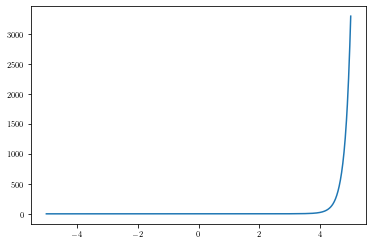

In [91]:
plt.plot(etas, lr_true)

### BCE

In [92]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':4}
params_2 = {'loss':tanh_bce, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it BCE $\phi$ Scan'
filename = 'plots/zenodo/scans/bce_phi.png'

In [93]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [94]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [95]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

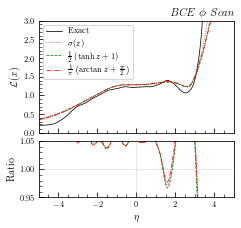

In [96]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### MSE

In [97]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':4}
params_2 = {'loss':tanh_mse, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it MSE $\phi$ Scan'
filename = 'plots/zenodo/scans/mse_phi.png'

In [98]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [99]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [100]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

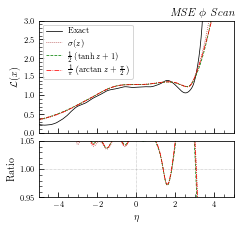

In [101]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### MLC

In [102]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 3)
title = r'\it MLC $\phi$ Scan'
filename = 'plots/zenodo/scans/mlc_phi.png'

In [103]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [104]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [105]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

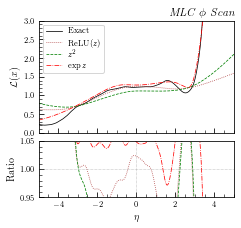

In [106]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### SQR

In [107]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 3)
title = r'\it MLC $\phi$ Scan'
filename = 'plots/zenodo/scans/mlc_phi.png'

In [108]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [109]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [110]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

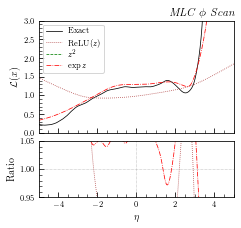

In [111]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

## $m$ Scan

In [112]:
# Get a one-dimensional slice of test points.
ms = np.linspace(0, 80, 1001).reshape(-1, 1)
pTs = np.repeat(mode_pT, len(ms)).reshape(-1, 1)
phis = np.repeat(mode_phi, len(ms)).reshape(-1, 1)
etas = np.repeat(mode_eta, len(ms)).reshape(-1, 1)

xs = np.hstack([pTs, etas, phis, ms])
var = ms
var_label = r'$m$'
var_string = 'm'

lr_true = lr(xs)

lr_true = lr(xs)

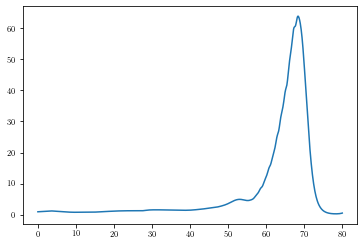

In [113]:
plt.plot(ms, lr_true)

### BCE

In [114]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':4}
params_2 = {'loss':tanh_bce, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it BCE $\phi$ Scan'
filename = 'plots/zenodo/scans/bce_phi.png'

In [115]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [116]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [117]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

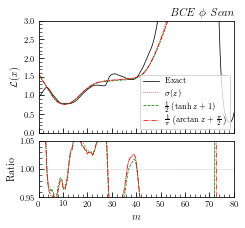

In [118]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### MSE

In [119]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':4}
params_2 = {'loss':tanh_mse, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it MSE $\phi$ Scan'
filename = 'plots/zenodo/scans/mse_phi.png'

In [120]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [121]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [122]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

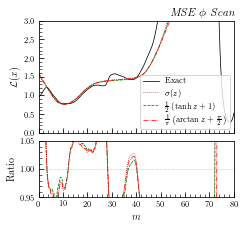

In [123]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### MLC

In [124]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 3)
title = r'\it MLC $\phi$ Scan'
filename = 'plots/zenodo/scans/mlc_phi.png'

In [125]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [126]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [127]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

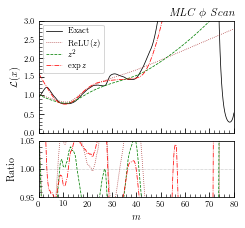

In [128]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

### SQR

In [129]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 3)
title = r'\it MLC $\phi$ Scan'
filename = 'plots/zenodo/scans/mlc_phi.png'

In [130]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [131]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

In [132]:
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)

lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

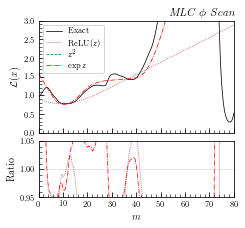

In [133]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i % len(cs)], 
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i % len(cs)],
                ls = lss[i % len(lss)],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.95, 1.05);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel('Ratio')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

# Scratch

In [340]:
N = 10**6
X_4 = np.load('data/zenodo/4/X_trn.npy')[:N]
y_4 = np.load('data/zenodo/4/y_trn.npy')[:N].astype('float32')
#data, m, s = split_data(X, y)

X_5 = np.load('data/zenodo/fold/5_old/X_trn.npy')[:N]
y_5 = np.load('data/zenodo/fold/5_old/y_trn.npy')[:N].astype('float32')

In [358]:
# Load in data.
mc = np.load("data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

mc_pt =  mc['sim_jets'][:, 0] 
mc_eta = mc['sim_jets'][:, 1]
mc_phi = mc['sim_jets'][:, 2]
mc_m =   mc['sim_jets'][:, 3]
mc_w = mc['sim_widths']
mc_sdms = mc['sim_sdms']

mc = np.vstack([mc_pt, mc_eta, mc_m, mc_w, mc_sdms]).T


dt = np.load("data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

dt_pt =  dt['sim_jets'][:, 0] 
dt_eta = dt['sim_jets'][:, 1]
dt_phi = dt['sim_jets'][:, 2]
dt_m =   dt['sim_jets'][:, 3]
dt_w = dt['sim_widths']
dt_sdms = dt['sim_sdms']

dt = np.vstack([dt_pt, dt_eta, dt_m, dt_w, dt_sdms]).T

n, d = mc.shape

In [341]:
from matplotlib import rc
rc('text', usetex=False)

In [349]:
min(X_4[:, 0]), max(X_4[:, 0])

(-442.62903, 1521.77)

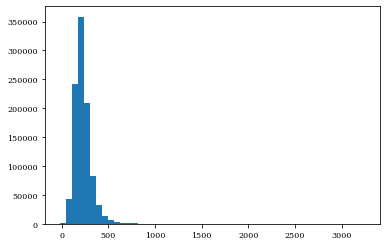

In [376]:
plt.hist(X_5[X_5[:, 0] > -20, 0], bins = 51);

In [383]:
min(X_4[:, 1]), max(X_4[:, 1])

(-5.8801866, 6.381986)

In [379]:
min(X_5[:, 1]), max(X_5[:, 1])

(-2475194600.0, 35799183000.0)

In [385]:
np.mean((X_5[:, 1] < -6) | (X_5[:, 1] > 7))

0.000103

In [380]:
min(X_5[:, 2]), max(X_5[:, 2])

(-12366857.0, 27590.432)

In [381]:
min(X_5[:, 3]), max(X_5[:, 3])

(-252134560.0, 31592.186)

In [382]:
min(X_5[:, 4]), max(X_5[:, 4])

(-441.0433, 2531.7422)

In [12]:
N = 10**6
X = np.load('data/zenodo/fold/6/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/6/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

X_trn, X_tst, y_trn, y_tst = data

In [13]:
params = {'loss':exp_sqr, 'd': 6, 'output': 'linear'}

In [14]:
model = create_model(**params, verbose = True)

In [15]:
model.compile(loss = exp_sqr, optimizer = 'adam', metrics = ['accuracy'])

In [17]:
model.fit(X_trn, y_trn, 
          epochs = 100, 
          batch_size = int(0.1*N), 
          validation_data = (X_tst, y_tst), 
          verbose = True)

Epoch 1/100
8/8 [==============================] - 6s 808ms/step - loss: 0.9937 - accuracy: 0.5009 - val_loss: 0.9933 - val_accuracy: 0.5009
Epoch 2/100
8/8 [==============================] - 6s 800ms/step - loss: 0.9936 - accuracy: 0.5011 - val_loss: 0.9929 - val_accuracy: 0.5012
Epoch 3/100
8/8 [==============================] - 6s 839ms/step - loss: 0.9932 - accuracy: 0.5019 - val_loss: 0.9925 - val_accuracy: 0.5019
Epoch 4/100
8/8 [==============================] - 5s 778ms/step - loss: 0.9929 - accuracy: 0.5033 - val_loss: 0.9923 - val_accuracy: 0.5031
Epoch 5/100
8/8 [==============================] - 6s 847ms/step - loss: 0.9929 - accuracy: 0.5046 - val_loss: 0.9921 - val_accuracy: 0.5037
Epoch 6/100
8/8 [==============================] - 5s 749ms/step - loss: 0.9928 - accuracy: 0.5050 - val_loss: 0.9920 - val_accuracy: 0.5037
Epoch 7/100
8/8 [==============================] - 6s 857ms/step - loss: 0.9927 - accuracy: 0.5049 - val_loss: 0.9920 - val_accuracy: 0.5034
Epoch 8/100
8

KeyboardInterrupt: 

In [ ]:
batch = X_tst[:256]
y_hat = model.predict(batch)

In [68]:
np.mean([exp_sqr(y_tst[i], y_hat[i]) for i in range(256)])

1.0000079

In [59]:
y_hat = model.predict(X_tst[:256])